# Task
Data
There are three datasets: customers.csv, purchases.csv and shops.csv. They are stored in data folder.

customers.csv contains information about each customer registered in loyalty program.

shops.csv contains information about shops and special offers they organized. One shap can organize several offers and therefore there are usually several rows that correspond to the same shops. However, some shops do not organize special offers at all, but they are presented in this table nevertheless.

purchases.csv is a purchase log. It contains information for all customers, either registered in a loyalty program (in this case we know the corresponding customer id) or not registered. One purchase can be a collection of several items, but we see only the total price of everything bought.

**Project goal: Analyze the results of promotions in stores**

# Data loading

In [6]:
import pandas as pd

customers = pd.read_csv('https://github.com/mbburova/MDS/raw/main/customers.csv', sep = ',')
purchases = pd.read_csv('https://github.com/mbburova/MDS/raw/main/purchases.csv', sep = ',')
shops = pd.read_csv('https://github.com/mbburova/MDS/raw/main/shops.csv')

In [7]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 867 entries, 0 to 866
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   customer id  867 non-null    int64  
 1   age          824 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 13.7 KB


In [8]:
customers.describe()

,customer id,age
count,867.000000,824.000000
mean,604.474048,43.791262
std,351.204914,18.115000
min,0.000000,12.000000
25%,299.500000,29.000000
50%,606.000000,43.000000
75%,900.500000,58.000000
max,1212.000000,88.000000


In [9]:
purchases.head(3)

,customer_id,date,shop_id,total_price
0,0.0,2018-05-04,40,289.673291
1,0.0,2019-01-26,40,1316.898901
2,0.0,2018-11-18,42,159.414367


In [10]:
shops.head(5)

,shop_id,offer_begin,offer_end
0,0,2019-02-28,2019-03-13
1,0,2018-07-22,2018-08-10
2,0,2018-09-21,2018-09-27
3,1,NaN,NaN
4,2,NaN,NaN


# Create Data Base

In [17]:
import sqlite3

connection = sqlite3.connect('data_base.db')
cursor = connection.cursor()

customers.columns = ['customer_id','age']

customers.to_sql('customers', con = connection, if_exists='replace', index=False)
purchases.to_sql('purchases', con = connection, if_exists='replace', index=False)
shops.to_sql('shops', con = connection, if_exists='replace', index=False)

183

In [19]:
c = cursor.execute('''
SELECT * FROM customers
''').fetchall()
p = cursor.execute('''
SELECT * FROM purchases
''').fetchall()
s = cursor.execute('''
SELECT * FROM shops
''').fetchall()

## Merging tables

In [21]:
## [2] LEFT JOIN (СОЗДАЛИ ТАБЛИЦУ С ПОКУПКАМИ И ВОЗРАСТОМ КЛИЕНТА)

ex1 = cursor.execute('''
SELECT p.*, c.age
FROM purchases p 
LEFT JOIN customers c
ON c.customer_id = p.customer_id
''').fetchall()

In [42]:
## [3] СОЗДАНИЕ ДАТА ФРЕЙМА

df_ex1 = pd.DataFrame(ex1, columns=['customer_id', 'date', 'shop_id', 'total_price', 'age'])

In [43]:
df_ex1

,customer_id,date,shop_id,total_price,age
0,0.0,2018-05-04,40,289.673291,38.0
1,0.0,2019-01-26,40,1316.898901,38.0
2,0.0,2018-11-18,42,159.414367,38.0
3,0.0,2018-05-12,42,808.791649,38.0
4,0.0,2019-04-20,42,1207.855038,38.0
...,...,...,...,...,...
40397,NaN,2018-05-05,37,169.086474,NaN
40398,NaN,2018-09-29,7,310.993395,NaN
40399,NaN,2018-10-31,1,17.535630,NaN
40400,NaN,2019-02-16,37,218.576020,NaN


## Pivot table: age and total price correlation

In [44]:
## СВОДНАЯ ТАБЛИЦА

age_totalprice = pd.pivot_table(df_ex1,
               index='customer_id',
               values=['total_price','age'],
               aggfunc = {'total_price':'mean','age':'mean'})

# age_totalprice_2 = pd.pivot_table(df_ex1,
#                index='customer_id',
#                values=['total_price','age'],
#                aggfunc = {'total_price':'sum','age':'mean'})

In [45]:
## УБРАТЬ ПУСТЫЕ ЗНАЧЕНИЯ (NaN)

age_totalprice = age_totalprice.dropna()

In [46]:
## ФОРМУЛА КОРЕЛЯЦИИ

import numpy as np

x_bar = np.mean(age_totalprice['age'])
y_bar = np.mean(age_totalprice['total_price'])

a = np.sum((age_totalprice['age'] - x_bar) * (age_totalprice['total_price'] - y_bar))
b = np.sqrt(np.sum((age_totalprice['age'] - x_bar)**2) * np.sum((age_totalprice['total_price'] - y_bar)**2))
r = a/b

In [47]:
r

0.16539508120771904

In [48]:
age_totalprice.corr()

,age,total_price
age,1.000000,0.165395
total_price,0.165395,1.000000


In [49]:
# age_totalprice_2.corr()

In [50]:
df_merge = purchases.merge(customers, how = 'left', on = 'customer_id')

In [51]:
df_merge

,customer_id,date,shop_id,total_price,age
0,0.0,2018-05-04,40,289.673291,38.0
1,0.0,2019-01-26,40,1316.898901,38.0
2,0.0,2018-11-18,42,159.414367,38.0
3,0.0,2018-05-12,42,808.791649,38.0
4,0.0,2019-04-20,42,1207.855038,38.0
...,...,...,...,...,...
40397,NaN,2018-05-05,37,169.086474,NaN
40398,NaN,2018-09-29,7,310.993395,NaN
40399,NaN,2018-10-31,1,17.535630,NaN
40400,NaN,2019-02-16,37,218.576020,NaN


## Pivot table: date and total price

In [52]:
date_totalprice = pd.pivot_table(df_ex1,
                            index='date',
                            values='total_price',
                            aggfunc = 'sum')

In [53]:
date_totalprice

,total_price
date,
2018-05-03,75898.830176
2018-05-04,39400.146775
2018-05-05,315037.619902
2018-05-06,34280.613190
2018-05-07,53.463907
...,...
2019-05-30,10872.218650
2019-05-31,13672.532304
2019-06-01,120067.671450


In [54]:
ex2 = cursor.execute('''
SELECT date, SUM(total_price) AS sumtp
FROM purchases AS p
GROUP BY date
''').fetchall()

In [55]:
df_ex2 = pd.DataFrame(ex2, columns=['date', 'total_price'])

In [56]:
merge_date = date_totalprice.merge(df_ex2, how = 'left', on = 'date')

In [57]:
merge_date[['total_price_x','total_price_y']] = np.round(merge_date[['total_price_x','total_price_y']])

In [58]:
merge_date[merge_date['total_price_x']!=merge_date['total_price_y']]

,date,total_price_x,total_price_y


In [59]:
merge_date.query('total_price_x != total_price_y')

,date,total_price_x,total_price_y


In [60]:
merge_date.query('total_price_x > 1000')

,date,total_price_x,total_price_y
0,2018-05-03,75899.0,75899.0
1,2018-05-04,39400.0,39400.0
2,2018-05-05,315038.0,315038.0
3,2018-05-06,34281.0,34281.0
5,2018-05-08,1357.0,1357.0
...,...,...,...
365,2019-05-29,10729.0,10729.0
366,2019-05-30,10872.0,10872.0
367,2019-05-31,13673.0,13673.0
368,2019-06-01,120068.0,120068.0


In [61]:
merge_date[merge_date['total_price_x']>1000]

,date,total_price_x,total_price_y
0,2018-05-03,75899.0,75899.0
1,2018-05-04,39400.0,39400.0
2,2018-05-05,315038.0,315038.0
3,2018-05-06,34281.0,34281.0
5,2018-05-08,1357.0,1357.0
...,...,...,...
365,2019-05-29,10729.0,10729.0
366,2019-05-30,10872.0,10872.0
367,2019-05-31,13673.0,13673.0
368,2019-06-01,120068.0,120068.0


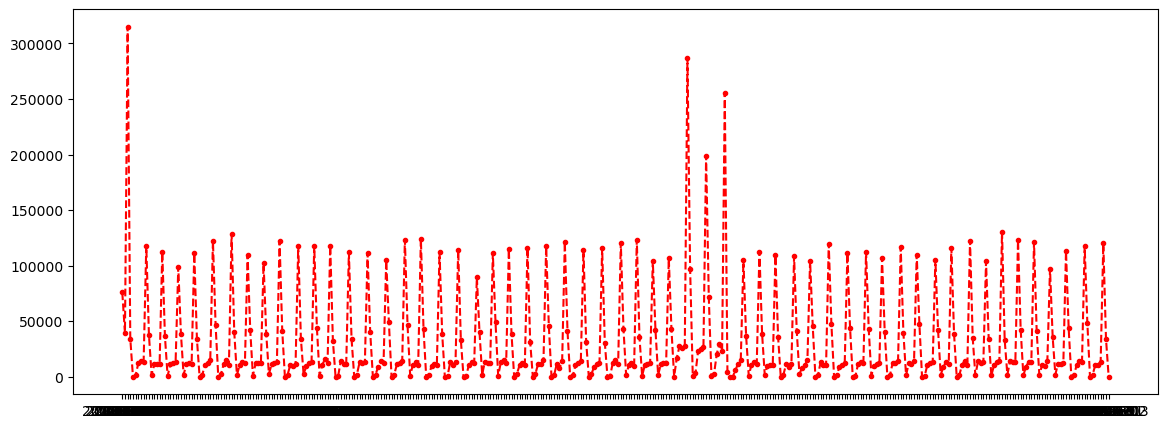

In [63]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,5))
plt.plot(date_totalprice,color = 'red',linestyle = '--',marker = 'o',markersize = 3)

In [64]:
date_totalprice

,total_price
date,
2018-05-03,75898.830176
2018-05-04,39400.146775
2018-05-05,315037.619902
2018-05-06,34280.613190
2018-05-07,53.463907
...,...
2019-05-30,10872.218650
2019-05-31,13672.532304
2019-06-01,120067.671450


## Python merging tables

In [68]:
pc = purchases.merge(customers, how = 'left', on = 'customer_id')

In [69]:
pc_pt = pc.pivot_table(index = 'customer_id',
               values = ['age', 'total_price'],
               aggfunc = 'mean')

In [70]:
pc_pt

,age,total_price
customer_id,,
0.0,38.0,711.291471
2.0,60.0,380.286822
3.0,NaN,392.825462
4.0,24.0,349.189551
5.0,24.0,472.189806
...,...,...
1206.0,57.0,251.489294
1207.0,42.0,525.552619
1208.0,31.0,640.826988


In [71]:
pc_pt = pc_pt.dropna()

In [72]:
pc_pt.corr()

,age,total_price
age,1.000000,0.165395
total_price,0.165395,1.000000


## Age and total price correlation visualisation

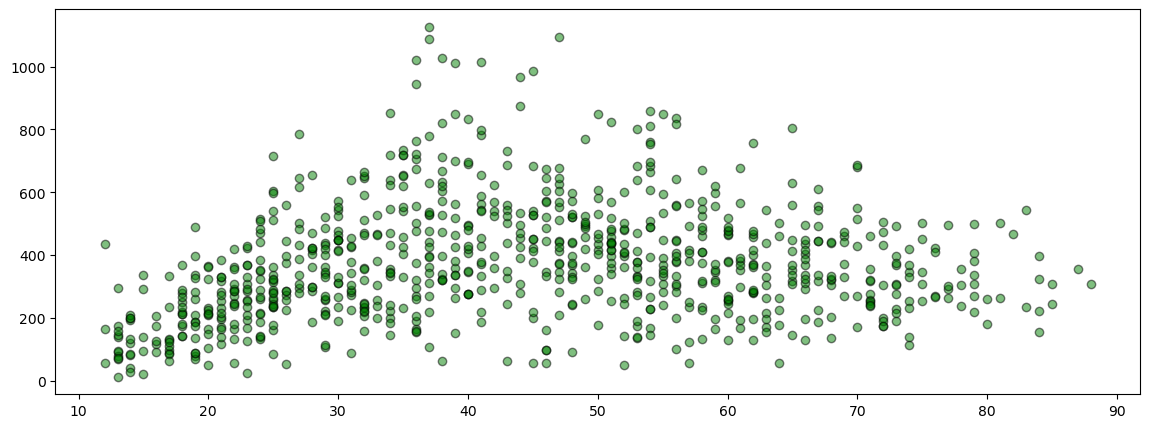

In [73]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,5))
plt.scatter(x = pc_pt['age'], y = pc_pt['total_price'], color = 'green', edgecolor = 'black', marker = 'o', alpha = 0.5)

In [74]:
pc_pt

,age,total_price
customer_id,,
0.0,38.0,711.291471
2.0,60.0,380.286822
4.0,24.0,349.189551
5.0,24.0,472.189806
7.0,71.0,256.105933
...,...,...
1206.0,57.0,251.489294
1207.0,42.0,525.552619
1208.0,31.0,640.826988


In [75]:
pc_pt_2 = pc_pt.pivot_table(index = 'age',
               values = 'total_price',
               aggfunc = 'mean').reset_index()

In [76]:
pc_pt_2

,age,total_price
0,12.0,219.186310
1,13.0,121.679651
2,14.0,129.574306
3,15.0,177.137115
4,16.0,143.512126
...,...,...
71,83.0,388.629631
72,84.0,274.172243
73,85.0,276.779148
74,87.0,356.858391


## Age and total price pivot table visualisation

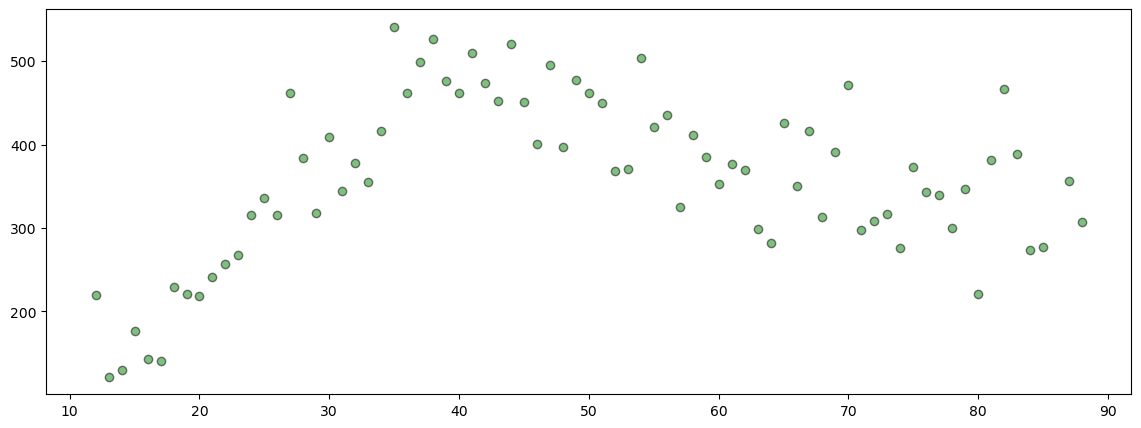

In [77]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,5))
plt.scatter(x = pc_pt_2['age'], y = pc_pt_2['total_price'], color = 'green', edgecolor = 'black', marker = 'o', alpha = 0.5)

In [78]:
pc_pt_2.corr()

,age,total_price
age,1.000000,0.224182
total_price,0.224182,1.000000


In [80]:
customers.head(3)

,customer_id,age
0,1149,71.0
1,750,21.0
2,428,36.0


In [81]:
purchases.head(3)

,customer_id,date,shop_id,total_price
0,0.0,2018-05-04,40,289.673291
1,0.0,2019-01-26,40,1316.898901
2,0.0,2018-11-18,42,159.414367


In [82]:
shops.head(3)

,shop_id,offer_begin,offer_end
0,0,2019-02-28,2019-03-13
1,0,2018-07-22,2018-08-10
2,0,2018-09-21,2018-09-27


In [83]:
pc = purchases.merge(customers, how = 'left', on = 'customer_id')

In [84]:
pc = pc.dropna()

In [85]:
pc.head(3)

,customer_id,date,shop_id,total_price,age
0,0.0,2018-05-04,40,289.673291,38.0
1,0.0,2019-01-26,40,1316.898901,38.0
2,0.0,2018-11-18,42,159.414367,38.0


In [86]:
pcs = pc.merge(shops, how = 'left', on = 'shop_id')

In [87]:
pcs

,customer_id,date,shop_id,total_price,age,offer_begin,offer_end
0,0.0,2018-05-04,40,289.673291,38.0,2018-08-15,2018-09-10
1,0.0,2019-01-26,40,1316.898901,38.0,2018-08-15,2018-09-10
2,0.0,2018-11-18,42,159.414367,38.0,2018-12-14,2019-01-21
3,0.0,2018-11-18,42,159.414367,38.0,2018-12-12,2019-01-04
4,0.0,2018-05-12,42,808.791649,38.0,2018-12-14,2019-01-21
...,...,...,...,...,...,...,...
66012,1212.0,2018-11-08,60,46.653544,24.0,2018-07-07,2018-08-02
66013,1212.0,2018-07-20,60,50.592132,24.0,2018-07-07,2018-08-02
66014,1212.0,2019-04-18,15,95.459705,24.0,NaN,NaN
66015,1212.0,2019-02-14,60,69.968788,24.0,2018-07-07,2018-08-02


In [88]:
pcs.dtypes

customer_id    float64
date            object
shop_id          int64
total_price    float64
age            float64
offer_begin     object
offer_end       object
dtype: object

In [89]:
pcs['date'] = pd.to_datetime(pcs['date'])
pcs['offer_begin'] = pd.to_datetime(pcs['offer_begin'])
pcs['offer_end'] = pd.to_datetime(pcs['offer_end'])

# Analysis of the results of promotions in the store

In [150]:
pcs

,customer_id,date,shop_id,total_price,age,offer_begin,offer_end
0,0.0,2018-05-04,40,289.673291,38.0,2018-08-15,2018-09-10
1,0.0,2019-01-26,40,1316.898901,38.0,2018-08-15,2018-09-10
2,0.0,2018-11-18,42,159.414367,38.0,2018-12-14,2019-01-21
3,0.0,2018-11-18,42,159.414367,38.0,2018-12-12,2019-01-04
4,0.0,2018-05-12,42,808.791649,38.0,2018-12-14,2019-01-21
...,...,...,...,...,...,...,...
66012,1212.0,2018-11-08,60,46.653544,24.0,2018-07-07,2018-08-02
66013,1212.0,2018-07-20,60,50.592132,24.0,2018-07-07,2018-08-02
66014,1212.0,2019-04-18,15,95.459705,24.0,NaT,NaT
66015,1212.0,2019-02-14,60,69.968788,24.0,2018-07-07,2018-08-02


In [152]:
pcs[(pcs['date']>pcs['offer_begin'])&(pcs['date']<pcs['offer_end'])]

,customer_id,date,shop_id,total_price,age,offer_begin,offer_end
23,0.0,2018-08-26,40,901.935686,38.0,2018-08-15,2018-09-10
67,2.0,2018-12-20,52,391.015773,60.0,2018-12-12,2019-01-19
75,2.0,2018-05-23,41,277.083807,60.0,2018-05-03,2018-05-27
76,2.0,2019-01-24,52,69.347995,60.0,2018-12-31,2019-01-30
86,2.0,2019-01-26,52,607.716829,60.0,2018-12-31,2019-01-30
...,...,...,...,...,...,...,...
65951,1210.0,2019-01-18,42,251.721546,41.0,2018-12-14,2019-01-21
65968,1210.0,2019-01-11,42,195.170201,41.0,2018-12-14,2019-01-21
65979,1210.0,2019-04-14,47,745.065521,41.0,2019-04-11,2019-05-06
66013,1212.0,2018-07-20,60,50.592132,24.0,2018-07-07,2018-08-02


In [160]:
pcs_index = pcs.query('date > offer_begin and date < offer_end').index

In [156]:
## метод возвращает сырые значения, функция производит расчет, принимает аргументы

In [168]:
pcs['offer_flag'] = 0

In [170]:
pcs

,customer_id,date,shop_id,total_price,age,offer_begin,offer_end,offer_flag
0,0.0,2018-05-04,40,289.673291,38.0,2018-08-15,2018-09-10,0
1,0.0,2019-01-26,40,1316.898901,38.0,2018-08-15,2018-09-10,0
2,0.0,2018-11-18,42,159.414367,38.0,2018-12-14,2019-01-21,0
3,0.0,2018-11-18,42,159.414367,38.0,2018-12-12,2019-01-04,0
4,0.0,2018-05-12,42,808.791649,38.0,2018-12-14,2019-01-21,0
...,...,...,...,...,...,...,...,...
66012,1212.0,2018-11-08,60,46.653544,24.0,2018-07-07,2018-08-02,0
66013,1212.0,2018-07-20,60,50.592132,24.0,2018-07-07,2018-08-02,0
66014,1212.0,2019-04-18,15,95.459705,24.0,NaT,NaT,0
66015,1212.0,2019-02-14,60,69.968788,24.0,2018-07-07,2018-08-02,0


In [184]:
pcs.loc[pcs_index,'offer_flag'] = 1

In [186]:
pcs

,customer_id,date,shop_id,total_price,age,offer_begin,offer_end,offer_flag
0,0.0,2018-05-04,40,289.673291,38.0,2018-08-15,2018-09-10,0
1,0.0,2019-01-26,40,1316.898901,38.0,2018-08-15,2018-09-10,0
2,0.0,2018-11-18,42,159.414367,38.0,2018-12-14,2019-01-21,0
3,0.0,2018-11-18,42,159.414367,38.0,2018-12-12,2019-01-04,0
4,0.0,2018-05-12,42,808.791649,38.0,2018-12-14,2019-01-21,0
...,...,...,...,...,...,...,...,...
66012,1212.0,2018-11-08,60,46.653544,24.0,2018-07-07,2018-08-02,0
66013,1212.0,2018-07-20,60,50.592132,24.0,2018-07-07,2018-08-02,1
66014,1212.0,2019-04-18,15,95.459705,24.0,NaT,NaT,0
66015,1212.0,2019-02-14,60,69.968788,24.0,2018-07-07,2018-08-02,0


In [192]:
pcs_pivot = pcs.pivot_table(index = ['customer_id','date'],
               values = ['offer_flag'],
               aggfunc = ['min','max'])

In [196]:
pcs_pivot.columns = ['min_offer_flag','max_offer_flag']

In [202]:
pcs_pivot.query('min_offer_flag == 0 and max_offer_flag == 1')

min_offer_flag  max_offer_flag
customer_id date                                      
2.0         2018-05-23               0               1
            2018-12-20               0               1
            2019-01-24               0               1
            2019-01-26               0               1
8.0         2018-12-27               0               1
...                                ...             ...
1208.0      2018-09-08               0               1
            2018-12-15               0               1
            2019-04-21               0               1
1210.0      2019-01-11               0               1
            2019-01-18               0               1

[2093 rows x 2 columns]

In [206]:
pcs.query('customer_id == 2 and date == "2018-05-23"')

C:\Users\Егор\AppData\Local\Temp\ipykernel_16100\1818439552.py:1: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  pcs.query('customer_id == 2 and date == "2018-05-23"')


,customer_id,date,shop_id,total_price,age,offer_begin,offer_end,offer_flag
74,2.0,2018-05-23,41,277.083807,60.0,2018-08-23,2018-09-18,0
75,2.0,2018-05-23,41,277.083807,60.0,2018-05-03,2018-05-27,1


In [208]:
pcs_pivot = pcs.pivot_table(index = ['customer_id','date','shop_id','total_price','age',],
               values = ['offer_flag'],
               aggfunc = 'max')

In [216]:
pcs_pivot = pcs_pivot.reset_index()

In [218]:
pcs_pivot

,customer_id,date,shop_id,total_price,age,offer_flag
0,0.0,2018-05-04,40,289.673291,38.0,0
1,0.0,2018-05-12,42,808.791649,38.0,0
2,0.0,2018-06-08,42,351.165885,38.0,0
3,0.0,2018-06-20,15,181.441359,38.0,0
4,0.0,2018-06-24,40,1005.693540,38.0,0
...,...,...,...,...,...,...
27414,1212.0,2019-04-07,60,148.105007,24.0,0
27415,1212.0,2019-04-18,15,95.459705,24.0,0
27416,1212.0,2019-04-24,15,88.252043,24.0,0
27417,1212.0,2019-04-27,15,529.868625,24.0,0


In [228]:
pcs_mean_total = pcs_pivot.pivot_table(index = ['customer_id','offer_flag',],
               values = ['total_price'],
               aggfunc = 'mean')

In [230]:
pcs_mean_total

total_price
customer_id offer_flag             
0.0         0            700.077105
            1            901.935686
2.0         0            386.571925
            1            336.291101
4.0         0            350.284865
...                             ...
1208.0      1           1098.911476
1210.0      0            280.723508
            1            397.319089
1212.0      0            221.380330
            1             89.963846

[1543 rows x 1 columns]

In [232]:
pcs_mean_total = pcs_pivot.pivot_table(
    index = 'customer_id',
    values = ['total_price'],
    aggfunc = 'mean',
    columns = 'offer_flag'
)                                  

In [240]:
pcs_mean_total.columns = ['not_offer','offer']

## Results of promotions

In [246]:
pcs_mean_total['not_offer'].mean()

355.4455602089925

In [248]:
pcs_mean_total['offer'].mean()

557.6876152882354

In [254]:
pcs_mean_total['offer'].mean() / pcs_mean_total['not_offer'].mean() - 1

0.5689818012084045